<a href="https://colab.research.google.com/github/jda-21/AI4ENG/blob/main/99%20-%20modelo%20soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


## Desarrollo del Modelo Final - CatBoost

Después de probar múltiples modelos y ejecutar varios notebooks exploratorios con modelos como Logistic regression, SVM, LightGBM, Random Forest, TensorFlow, se determinó que CatBoost ofrece el mejor rendimiento para este problema.

Durante el proceso se evaluaron diferentes configuraciones, tamaños de muestra e hiperparámetros. CatBoost destacó por varias razones y *accuracy.*
	•	Rendimiento notable en F1-macro, para este caso multi clase.
	•	Estabilidad con muestras grandes, reflejado en las curvas de aprendizaje.
	•	Manejo nativo de variables categóricas, sin necesidad de OHE.
	•	Entrenamiento eficiente, tiempos aceptables.

Debido a esto, CatBoost fue seleccionado como el modelo principal para el desarrollo final.

En las siguientes secciones se muestra el desarrollo definitivo: preprocesamiento, entrenamiento con los mejores hiperparámetros identificados y generación del archivo de submission para la competencia.

### Carga de datasets

In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from catboost import CatBoostClassifier, Pool
from IPython.display import display

TRAIN_PATH = "/content/df_binaryAdj2.csv"

df = pd.read_csv(TRAIN_PATH)
print("Shape:", df.shape)

TARGET_COL = "RENDIMIENTO_GLOBAL_NUM"

print("4Conteo de clases target")
print(df[TARGET_COL].value_counts().sort_index())

Shape: (692500, 20)
Conteo de clases target
RENDIMIENTO_GLOBAL_NUM
1    172987
2    172275
3    171619
4    175619
Name: count, dtype: int64


## Setup Catboost

Aquí se prepara el dataset separando las variables predictoras y la etiqueta objetivo. Se define la función que entrena el modelo usando distintos tamaños de muestra, con la cual se podía ver la evolución del rendimiento a medida que aumenta el volumen de datos.

**Hiperparámetros** óptimos encontrados previamente:
- *depth=6* (controla la complejidad del árbol),
- learning_rate=0.05 (equilibra convergencia y estabilidad)
- l2_leaf_reg=5 (reduce sobreajuste)
- iterations=700 (cantidad suficiente para estabilizar el F1)
- od_wait=50 (detiene el entrenamiento si no hay mejora)

Cada configuración se evalúa usando ***accuracy*** y *F1-macro*, métricas adecuadas para un problema multiclase. Estos resultados permiten determinar el tamaño mínimo de datos necesario y validar la robustez del modelo antes de la fase final de entrenamiento.

In [7]:
X_full = df.drop(columns=[TARGET_COL])
y_full = df[TARGET_COL].astype(int)

cat_cols = X_full.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_idx  = [X_full.columns.get_loc(c) for c in cat_cols]

print("Total de columnas:", X_full.shape[1])
N = len(df)

Total de columnas: 19


In [8]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from catboost import CatBoostClassifier, Pool

def train_and_evaluate_catboost(size, random_state=42):

    if size == "full":
        idx_sub = np.arange(N)
    else:
        size = int(size)
        if size >= N:
            idx_sub = np.arange(N)
        else:
            sss = StratifiedShuffleSplit(
                n_splits=1,
                train_size=size,
                random_state=random_state
            )
            for idx_sub, _ in sss.split(X_full, y_full):
                break

    X = X_full.iloc[idx_sub].copy()
    y = y_full.iloc[idx_sub].copy()

    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=random_state,
        stratify=y
    )

    train_pool = Pool(X_train, label=y_train, cat_features=cat_idx)
    val_pool   = Pool(X_val,   label=y_val,   cat_features=cat_idx)

    model = CatBoostClassifier(
        loss_function="MultiClass",
        eval_metric="TotalF1",
        depth=6,
        learning_rate=0.05,
        l2_leaf_reg=5,
        iterations=700,
        random_seed=random_state,
        od_type="Iter",
        od_wait=50,
        verbose=0,
        task_type="CPU"
    )

    t0 = time.time()
    model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    elapsed = time.time() - t0

    y_pred = model.predict(val_pool, prediction_type="Class").ravel().astype(int)
    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average="macro")

    return acc, f1_macro, elapsed

In [9]:
print("Curva de aprendizaje CatBoost")

sizes = [1000, 5000, 10000, 20000, 50000,
         100000, 200000, 350000, "full"]

results = []
for size in sizes:
    print(f"\nEntrenando tamaño = {size}")
    acc, f1m, elapsed = train_and_evaluate_catboost(size)
    print(f" -> accuracy={acc:.4f}, f1_macro={f1m:.4f}, tiempo={elapsed:.2f} s")
    results.append((size, acc, f1m, elapsed))

results_df = pd.DataFrame(results, columns=["size", "accuracy", "f1_macro", "time_sec"])

from IPython.display import display
print("\nResultados curva de aprendizaje:")
display(results_df)

Curva de aprendizaje CatBoost

Entrenando tamaño = 1000
 -> accuracy=0.4400, f1_macro=0.4365, tiempo=2.64 s

Entrenando tamaño = 5000
 -> accuracy=0.4080, f1_macro=0.3907, tiempo=12.68 s

Entrenando tamaño = 10000
 -> accuracy=0.4070, f1_macro=0.3911, tiempo=24.74 s

Entrenando tamaño = 20000
 -> accuracy=0.4220, f1_macro=0.4138, tiempo=94.22 s

Entrenando tamaño = 50000
 -> accuracy=0.4296, f1_macro=0.4131, tiempo=99.99 s

Entrenando tamaño = 100000
 -> accuracy=0.4434, f1_macro=0.4292, tiempo=387.30 s

Entrenando tamaño = 200000
 -> accuracy=0.4348, f1_macro=0.4248, tiempo=853.38 s

Entrenando tamaño = 350000
 -> accuracy=0.4408, f1_macro=0.4298, tiempo=1289.70 s

Entrenando tamaño = full
 -> accuracy=0.4411, f1_macro=0.4316, tiempo=2472.35 s

Resultados curva de aprendizaje:


,size,accuracy,f1_macro,time_sec
0,1000,0.440000,0.436520,2.640285
1,5000,0.408000,0.390669,12.680032
2,10000,0.407000,0.391066,24.739737
3,20000,0.422000,0.413776,94.219619
4,50000,0.429600,0.413067,99.986982
5,100000,0.443400,0.429183,387.304158
6,200000,0.434800,0.424813,853.380402
7,350000,0.440800,0.429760,1289.697236
8,full,0.441076,0.431598,2472.354429


## Performance and learning curves

En las gráfica de **curva de aprendizaje** se refleja el aumento de rendimiento del modelo al aumentar el tamaño del conjunto de entrenamiento. Se observa que cómo los indicadores son inestables en tamaños pequeños, pero se estabilizan progresivamente. Desde ese punto, el modelo presenta mejoras consistentes y alcanza su rendimiento máximo alrededor de los *150k–350k.*

La segunda gráfica, **tiempo de entrenamiento**, muestra un crecimiento lineal, por supuesto esperado, conforme aumenta el tamaño del dataset.

Se tiene que el modelo aprende de forma estable, mejora cuando se le suministra más información y alcanza un punto aceptable donde las métricas dejan de variar significativamente. Este comportamiento confirma que los hiperparámetros elegidos son adecuados y que el modelo está listo para la inferencia sobre los datos de prueba.

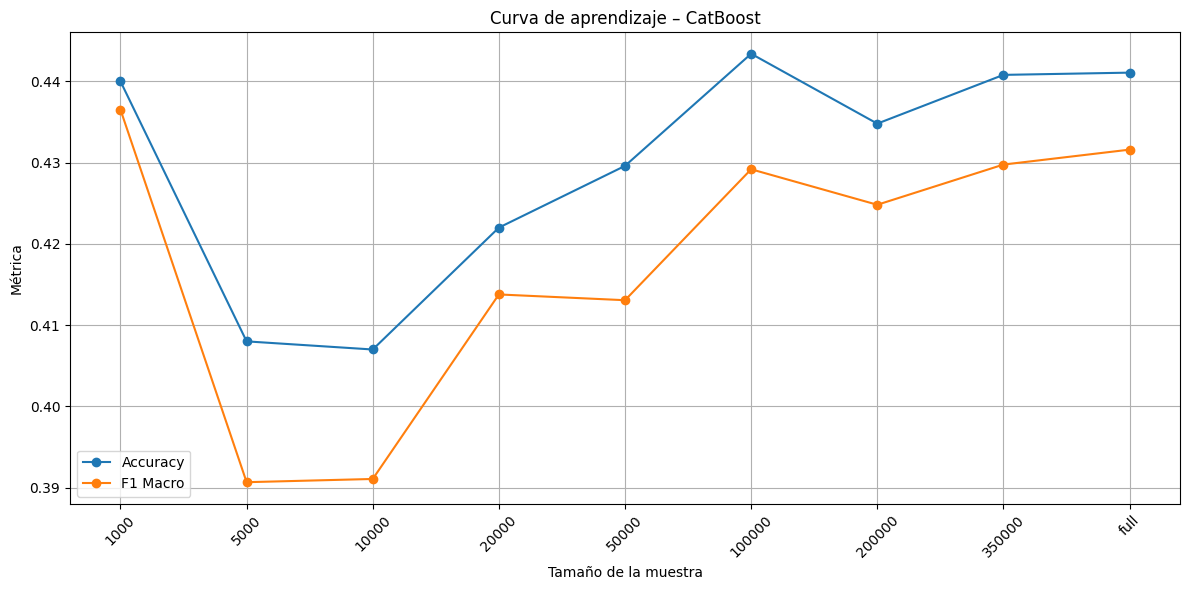

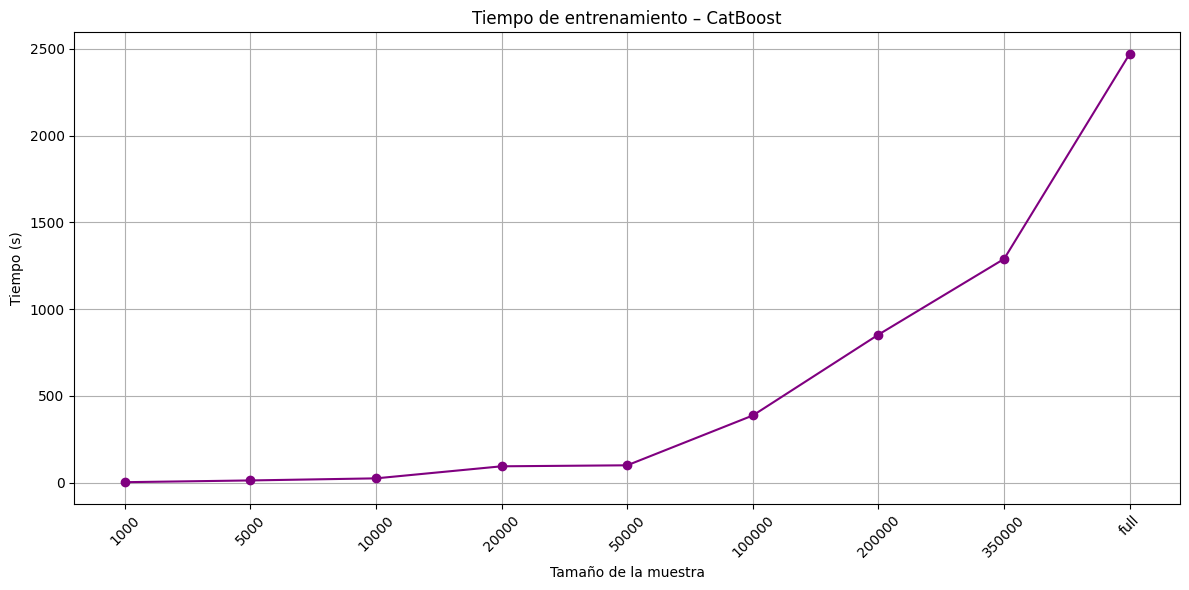

In [10]:
import matplotlib.pyplot as plt

x_labels = [str(s) for s in results_df["size"]]
x_values = np.arange(len(x_labels))

plt.figure(figsize=(12,6))
plt.plot(x_values, results_df["accuracy"], marker="o", label="Accuracy")
plt.plot(x_values, results_df["f1_macro"], marker="o", label="F1 Macro")
plt.xticks(x_values, x_labels, rotation=45)
plt.xlabel("Tamaño de la muestra")
plt.ylabel("Métrica")
plt.title("Curva de aprendizaje – CatBoost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(x_values, results_df["time_sec"], marker="o", color="purple")
plt.xticks(x_values, x_labels, rotation=45)
plt.xlabel("Tamaño de la muestra")
plt.ylabel("Tiempo (s)")
plt.title("Tiempo de entrenamiento – CatBoost")
plt.grid(True)
plt.tight_layout()
plt.show()

# Entrenamiento Final del Modelo y Exportación

Para concluir el proceso, se realizó un entrenamiento completo del modelo utilizando el 80% de los datos para entrenamiento y el 20% restante para validación. Se aplicaron los mismos hiperparámetros óptimos obtenidos durante la fase de experimentación.

Tras el entrenamiento, se calcularon las métricas finales *—Accuracy y F1-Macro—* junto con el reporte de clasificación y la matriz de confusión, lo que permitió verificar que el desempeño alcanzado es consistente con el observado en las curvas de aprendizaje. Una vez confirmado el rendimiento, el modelo entrenado se guardó en un archivo *.cbm.*

Este archivo contiene el modelo completo, sus árboles, pesos y configuraciones internas, y permite cargarlo posteriormente sin necesidad de volver a entrenarlo, optimizando tiempos de ejecución y facilitando la generación eficiente del archivo de predicciones para el dataset de prueba.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

train_pool_full = Pool(X_train, label=y_train, cat_features=cat_idx)
val_pool_full   = Pool(X_val,   label=y_val,   cat_features=cat_idx)

final_model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="TotalF1",
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=5,
    iterations=700,
    random_seed=42,
    od_type="Iter",
    od_wait=50,
    verbose=100,
    task_type="CPU"
)

final_model.fit(train_pool_full, eval_set=val_pool_full, use_best_model=True)

y_pred_full = final_model.predict(val_pool_full, prediction_type="Class").ravel().astype(int)

acc_full = accuracy_score(y_val, y_pred_full)
f1_full  = f1_score(y_val, y_pred_full, average="macro")

print("MÉTRICAS FINALES")
print(f"Accuracy:  {acc_full:.4f}")
print(f"F1-macro: {f1_full:.4f}")

print("Reporte de clasificación:")
print(classification_report(y_val, y_pred_full))

print("Matriz de confusión:")
cm = confusion_matrix(y_val, y_pred_full)
print(cm)

MODEL_PATH = "/content/catboost_model.cbm"
final_model.save_model(MODEL_PATH)

0:	learn: 0.3406327	test: 0.3407122	best: 0.3407122 (0)	total: 5.01s	remaining: 58m 22s
100:	learn: 0.4225567	test: 0.4241398	best: 0.4241398 (100)	total: 7m 49s	remaining: 46m 27s
200:	learn: 0.4277505	test: 0.4287844	best: 0.4287844 (200)	total: 15m 50s	remaining: 39m 18s
300:	learn: 0.4308061	test: 0.4307539	best: 0.4307539 (300)	total: 23m 39s	remaining: 31m 21s
400:	learn: 0.4330064	test: 0.4319725	best: 0.4321882 (389)	total: 32m	remaining: 23m 52s
500:	learn: 0.4340781	test: 0.4325055	best: 0.4325918 (462)	total: 40m 19s	remaining: 16m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4325918353
bestIteration = 462

Shrink model to first 463 iterations.
MÉTRICAS FINALES
Accuracy:  0.4411
F1-macro: 0.4316
Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.47      0.57      0.51     34597
           2       0.33      0.27      0.29     34455
           3       0.34      0.30      0.32     34324
           4   

In [12]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool

TRAIN_PATH = "/content/df_binaryAdj2.csv"
TEST_PATH  = "/content/test_clean_adj.csv"
MODEL_PATH = "/content/catboost_model.cbm"
SUB_PATH   = "/content/submission_catboost.csv"

TARGET_COL = "RENDIMIENTO_GLOBAL_NUM"

In [15]:
train_df = pd.read_csv(TRAIN_PATH)

X_train_full = train_df.drop(columns=[TARGET_COL])
feature_cols = X_train_full.columns.tolist()

cat_cols = X_train_full.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
cat_idx  = [X_train_full.columns.get_loc(c) for c in cat_cols]

df_test = pd.read_csv(TEST_PATH)

for c in feature_cols:
    if c not in df_test.columns:
        df_test[c] = 0

X_test = df_test[feature_cols].copy()

num_cols_test = X_test.select_dtypes(include=[np.number]).columns
X_test[num_cols_test] = X_test[num_cols_test].fillna(X_test[num_cols_test].median())

model = CatBoostClassifier()
model.load_model(MODEL_PATH)

test_pool = Pool(X_test, cat_features=cat_idx)

In [16]:
y_pred_num = model.predict(test_pool, prediction_type="Class").ravel().astype(int)

map_back = {
    1: "bajo",
    2: "medio-bajo",
    3: "medio-alto",
    4: "alto"
}

y_pred_str = pd.Series(y_pred_num).map(map_back)

submission = pd.DataFrame({
    "ID": df_test["ID"],
    "RENDIMIENTO_GLOBAL": y_pred_str
})

submission.to_csv(SUB_PATH, index=False)
print("Archivo generado:", SUB_PATH)

Archivo generado: /content/submission_catboost.csv


## Resultado en Kaggle

Se genera el archivo de predicción **m9submission_catboost.csv** y es entregado en Kaggle.

El resultado obtenido fue:

### **Public Score: 0.43886**